# Laboratory 6 homework

Homework is applying all techniques learned during the lab on the
[Banking77 dataset](https://huggingface.co/datasets/PolyAI/banking77).
It consists of online banking queries, annotated with their corresponding intents, resulting in 77 classes.
It's already split into training and testing parts, with F1 score typically used for evaluation.
It is also [known to have label errors](https://aclanthology.org/2022.insights-1.19/),
great for data-centric AI approach.
Label descriptions are [available here](https://huggingface.co/datasets/PolyAI/banking77#data-fields).

Instructions:
- do tasks in order, they have been designed to build upon prior steps
- write clean code, descriptive variable and function names, use comments where necessary etc.
- send your resulting application code as .zip file

1. Download and load the data. Perform the initial exploration and cleaning.
   - it is already split into training and testing parts
   - labels go from 0 to 76
   - checks should include e.g.:
     - checking data types, number of texts,

In [1]:
import polars as pl
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

dataset = load_dataset("PolyAI/banking77")

def dataset_to_polars(split_data):
    pandas_df = split_data.to_pandas()
    polars_df = pl.from_pandas(pandas_df)
    return polars_df

train_df = dataset_to_polars(dataset["train"])
test_df = dataset_to_polars(dataset["test"])

In [2]:
labels_desc = {
    0: "activate_my_card",
    1: "age_limit",
    2: "apple_pay_or_google_pay",
    3: "atm_support",
    4: "automatic_top_up",
    5: "balance_not_updated_after_bank_transfer",
    6: "balance_not_updated_after_cheque_or_cash_deposit",
    7: "beneficiary_not_allowed",
    8: "cancel_transfer",
    9: "card_about_to_expire",
    10: "card_acceptance",
    11: "card_arrival",
    12: "card_delivery_estimate",
    13: "card_linking",
    14: "card_not_working",
    15: "card_payment_fee_charged",
    16: "card_payment_not_recognised",
    17: "card_payment_wrong_exchange_rate",
    18: "card_swallowed",
    19: "cash_withdrawal_charge",
    20: "cash_withdrawal_not_recognised",
    21: "change_pin",
    22: "compromised_card",
    23: "contactless_not_working",
    24: "country_support",
    25: "declined_card_payment",
    26: "declined_cash_withdrawal",
    27: "declined_transfer",
    28: "direct_debit_payment_not_recognised",
    29: "disposable_card_limits",
    30: "edit_personal_details",
    31: "exchange_charge",
    32: "exchange_rate",
    33: "exchange_via_app",
    34: "extra_charge_on_statement",
    35: "failed_transfer",
    36: "fiat_currency_support",
    37: "get_disposable_virtual_card",
    38: "get_physical_card",
    39: "getting_spare_card",
    40: "getting_virtual_card",
    41: "lost_or_stolen_card",
    42: "lost_or_stolen_phone",
    43: "order_physical_card",
    44: "passcode_forgotten",
    45: "pending_card_payment",
    46: "pending_cash_withdrawal",
    47: "pending_top_up",
    48: "pending_transfer",
    49: "pin_blocked",
    50: "receiving_money",
    51: "refund_not_showing_up",
    52: "request_refund",
    53: "reverted_card_payment",
    54: "supported_cards_and_currencies",
    55: "terminate_account",
    56: "top_up_by_bank_transfer_charge",
    57: "top_up_by_card_charge",
    58: "top_up_by_cash_or_cheque",
    59: "top_up_failed",
    60: "top_up_limits",
    61: "top_up_reverted",
    62: "topping_up_by_card",
    63: "transaction_charged_twice",
    64: "transfer_fee_charged",
    65: "transfer_into_account",
    66: "transfer_not_received_by_recipient",
    67: "transfer_timing",
    68: "unable_to_verify_identity",
    69: "verify_my_identity",
    70: "verify_source_of_funds",
    71: "verify_top_up",
    72: "virtual_card_not_working",
    73: "visa_or_mastercard",
    74: "why_verify_identity",
    75: "wrong_amount_of_cash_received",
    76: "wrong_exchange_rate_for_cash_withdrawal"
}

In [3]:
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

Training data shape: (10003, 2)
Testing data shape: (3080, 2)


In [4]:
print(train_df.schema)
train_df.head()

Schema([('text', String), ('label', Int64)])


text,label
str,i64
"""I am still waiting on my card?""",11
"""What can I do if my card still…",11
"""I have been waiting over a wee…",11
"""Can I track my card while it i…",11
"""How do I know if I will get my…",11


In [5]:
print(test_df.schema)
test_df.head()

Schema([('text', String), ('label', Int64)])


text,label
str,i64
"""How do I locate my card?""",11
"""I still have not received my n…",11
"""I ordered a card but it has no…",11
"""Is there a way to know when my…",11
"""My card has not arrived yet.""",11


- plotting the class distribution

Total number of unique classes: 77


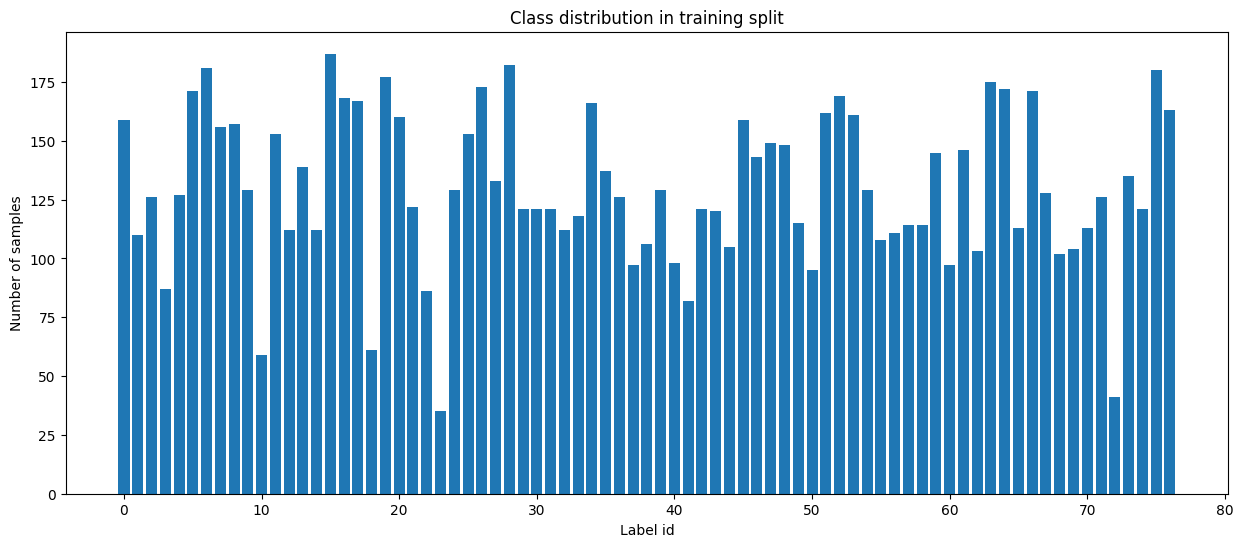

Minimum samples per class: 35
Maximum samples per class: 187


In [6]:
class_counts = train_df.group_by("label").len().sort("label")

class_names = dataset["train"].features["label"].names
num_classes = len(class_names)
print(f"Total number of unique classes: {num_classes}")

plot_data = class_counts.select(["label", "len"]).rows()
labels = [item[0] for item in plot_data]
counts = [item[1] for item in plot_data]

plt.figure(figsize=(15, 6))
plt.bar(labels, counts)
plt.title('Class distribution in training split')
plt.xlabel('Label id')
plt.ylabel('Number of samples')
plt.show()

min_count = class_counts["len"].min()
max_count = class_counts["len"].max()
print(f"Minimum samples per class: {min_count}")
print(f"Maximum samples per class: {max_count}")

- plotting the histogram of text lengths

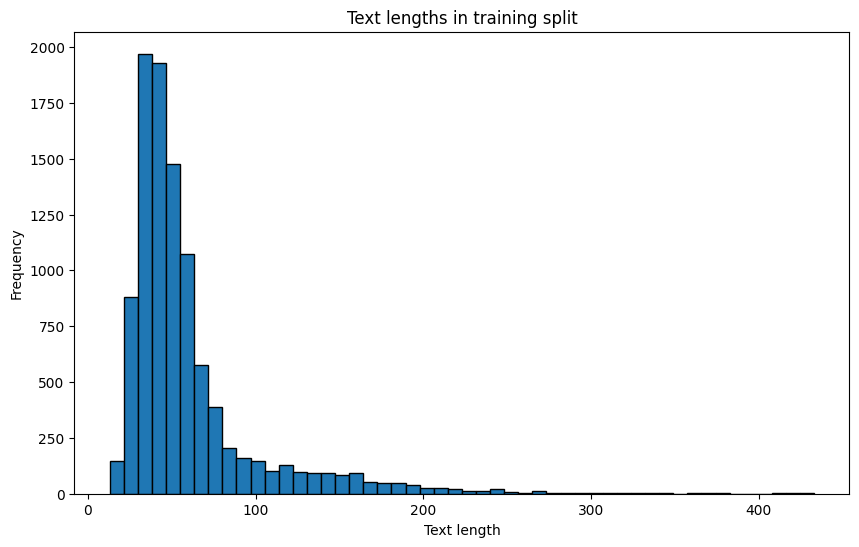

In [7]:
train_df = train_df.with_columns(
    pl.col("text").str.len_chars().alias("text_length")
)
test_df = test_df.with_columns(
    pl.col("text").str.len_chars().alias("text_length")
)

train_lengths = train_df["text_length"].to_list()

plt.figure(figsize=(10, 6))
plt.hist(train_lengths, bins=50, edgecolor='black')
plt.title('Text lengths in training split')
plt.xlabel('Text length')
plt.ylabel('Frequency')
plt.show()

2. Use CleanLab to detect and fix data quality issues:
   - use `all-MiniLM-L6-v2` Sentence Transformer embeddings + logistic regression as the model
   - note that `LogisticRegressionCV` works out-of-the-box for multiclass classification, and
     you should use `class_weight="balanced"` in case of class imbalance
   - detect and fix: label issues, near duplicates, outliers
   - when analyzing duplicates, you can print rows at given indices with `.iloc[]`
   - comment:
     - do your results agree with [the paper](https://aclanthology.org/2022.insights-1.19/)
       pointing out the label quality issues?
     - are the problems severe and worth fixing in your opinion?

In [8]:
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_predict


def get_initial_model_data(texts: np.ndarray, labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(texts)

    log_reg = LogisticRegressionCV(class_weight="balanced", random_state=0)
    pred_probs = cross_val_predict(estimator=log_reg, X=embeddings, y=labels, method="predict_proba")

    return embeddings, pred_probs

In [9]:
texts = train_df["text"].to_numpy()
labels = train_df["label"].to_numpy()
embeddings, pred_probs = get_initial_model_data(texts, labels)

In [10]:
from cleanlab import Datalab

data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 633 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         151
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

- label issues

In [11]:
df_cleaned = train_df.to_pandas().copy()

In [12]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred):
    print(f"y_true {labels_desc[y_true]}, y_pred {labels_desc[y_pred]}, text: {text}")
    print()

Top 10 label issues
y_true card_arrival, y_pred card_not_working, text: WHAT IS THE SOLUTION OF THIS PROBLEM

y_true disposable_card_limits, y_pred getting_virtual_card, text: i am not a premium customer but i want a virtual card, how do i get it

y_true lost_or_stolen_card, y_pred card_arrival, text: Can you tell me the status of my new card?

y_true declined_transfer, y_pred beneficiary_not_allowed, text: please help me with this transfer, for some reason i can't transfer to a cryptocurency account

y_true card_not_working, y_pred pin_blocked, text: Can I use app to reset PIN attempts?

y_true pin_blocked, y_pred get_physical_card, text: Where do I find PIN for my card?

y_true pending_top_up, y_pred topping_up_by_card, text: i put money on my card and i dont see it on the balance

y_true declined_cash_withdrawal, y_pred card_not_working, text: Is my card actually working? It's the first time I tried using it

y_true transfer_into_account, y_pred supported_cards_and_currencies, text:

In [13]:
label_issues = label_issues[label_issues.index.isin(df_cleaned.index)]

idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]

df_cleaned = df_cleaned.copy()
df_cleaned.loc[idxs, "label"] = pred_labels
df_cleaned

,text,label,text_length
0,I am still waiting on my card?,11,30
1,What can I do if my card still hasn't arrived ...,11,60
2,I have been waiting over a week. Is the card s...,11,58
3,Can I track my card while it is in the process...,11,59
4,"How do I know if I will get my card, or if it ...",11,54
...,...,...,...
9998,You provide support in what countries?,24,38
9999,What countries are you supporting?,24,34
10000,What countries are getting support?,24,35
10001,Are cards available in the EU?,24,30


- duplicate issues

In [14]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

for idx, row in duplicate_issues.tail(10).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

Text: What should I do if I can't prove my identity.
	Duplicates: ["What do I do if I can't prove my identity?"]

Text: How can I receive a virtual card?
	Duplicates: ['How do I receive a virtual card?']

Text: How do I receive a virtual card?
	Duplicates: ['How can I receive a virtual card?']

Text: Can you please tell me why my transfer failed?
	Duplicates: ['Can you please explain why my transfer failed?']

Text: Can you please explain why my transfer failed?
	Duplicates: ['Can you please tell me why my transfer failed?']

Text: Is there a limit to a disposable virtual card?
	Duplicates: ['Is there a limit to using a disposable virtual card?']

Text: Is there a limit to using a disposable virtual card?
	Duplicates: ['Is there a limit to a disposable virtual card?']

Text: Can I top up any amount?
	Duplicates: ['Can I top-up any amount?']

Text: Can I top-up any amount?
	Duplicates: ['Can I top up any amount?']

Text: How long will a transfer from the US take?
	Duplicates: ['How long

In [15]:
# https://docs.cleanlab.ai/v2.6.3/tutorials/faq.html
from typing import Callable
import pandas as pd


def merge_duplicate_sets(df, merge_key: str):
    """Generate group keys for each row, then merge intersecting sets.

    :param df: DataFrame with columns 'is_near_duplicate_issue' and 'near_duplicate_sets'
    :param merge_key: Name of the column to store the merged sets
    """

    df[merge_key] = df.apply(construct_group_key, axis=1)
    merged_sets = consolidate_sets(df[merge_key].tolist())
    df[merge_key] = df[merge_key].map(
        lambda x: next(s for s in merged_sets if x.issubset(s))
    )
    return df

def construct_group_key(row):
    """Convert near_duplicate_sets into a frozenset and include the row's own index."""
    return frozenset(row['near_duplicate_sets']).union({row.name})

def consolidate_sets(sets_list):
    """Merge sets if they intersect."""

    # Convert the input list of frozensets to a list of mutable sets
    sets_list = [set(item) for item in sets_list]

    # A flag to keep track of whether any sets were merged in the current iteration
    merged = True

    # Continue the merging process as long as we have merged some sets in the previous iteration
    while merged:
        merged = False
        new_sets = []

        # Iterate through each set in our list
        for current_set in sets_list:
            # Skip empty sets
            if not current_set:
                continue

            # Find all sets that have an intersection with the current set
            intersecting_sets = [s for s in sets_list if s & current_set]

            # If more than one set intersects, set the merged flag to True
            if len(intersecting_sets) > 1:
                merged = True

            # Merge all intersecting sets into one set
            merged_set = set().union(*intersecting_sets)
            new_sets.append(merged_set)

            # Empty the sets we've merged to prevent them from being processed again
            for s in intersecting_sets:
                sets_list[sets_list.index(s)] = set()

        # Replace the original sets list with the new list of merged sets
        sets_list = new_sets

    # Convert the merged sets back to frozensets for the output
    return [frozenset(item) for item in sets_list]

def lowest_score_strategy(sub_df):
    """Keep the row with the lowest near_duplicate_score."""
    return sub_df['near_duplicate_score'].idxmin()

def filter_near_duplicates(data: pd.DataFrame, strategy_fn: Callable = lowest_score_strategy, **strategy_kwargs):
    """
    Given a dataframe with columns 'is_near_duplicate_issue' and 'near_duplicate_sets',
    return a series of boolean values where True indicates the rows to be removed.
    The strategy_fn determines which rows to keep within each near_duplicate_set.

    :param data: DataFrame with is_near_duplicate_issue and near_duplicate_sets columns
    :param strategy_fn: Function to determine which rows to keep within each near_duplicate_set
    :return: Series of boolean values where True indicates rows to be removed.
    """

    # Filter out rows where 'is_near_duplicate_issue' is True to get potential duplicates
    duplicate_rows = data.query("is_near_duplicate_issue").copy()

    # Generate group keys for each row and merge intersecting sets
    group_key = "sets"
    duplicate_rows = merge_duplicate_sets(duplicate_rows, merge_key=group_key)

    # Use the strategy function to determine the indices of the rows to keep for each group
    to_keep_indices = duplicate_rows.groupby(group_key).apply(strategy_fn, **strategy_kwargs).explode().values

    # Produce a boolean series indicating which rows should be removed
    to_remove = ~data.index.isin(to_keep_indices)

    return to_remove

In [16]:
ids_to_remove = filter_near_duplicates(duplicate_issues)
df_cleaned = df_cleaned.drop(duplicate_issues[ids_to_remove].index)
df_cleaned

,text,label,text_length
0,I am still waiting on my card?,11,30
1,What can I do if my card still hasn't arrived ...,11,60
2,I have been waiting over a week. Is the card s...,11,58
3,Can I track my card while it is in the process...,11,59
4,"How do I know if I will get my card, or if it ...",11,54
...,...,...,...
9998,You provide support in what countries?,24,38
9999,What countries are you supporting?,24,34
10000,What countries are getting support?,24,35
10001,Are cards available in the EU?,24,30


- outlier

In [17]:
outlier_issues = lab.get_issues("outlier")
outlier_issues = outlier_issues[outlier_issues["is_outlier_issue"]]
outlier_issues = outlier_issues.sort_values(by="outlier_score")

top_outlier_issues_idxs = outlier_issues.head(10).index
top_outlier_issues_texts = texts[top_outlier_issues_idxs]
top_outlier_issues_labels = labels[top_outlier_issues_idxs]

print("Top 10 outlier issues")
for text, y_true in zip(top_outlier_issues_texts, top_outlier_issues_labels):
    print(f"label: {labels_desc[y_true]}, text: {text}")
    print()

Top 10 outlier issues
label: card_acceptance, text: WHAT IS THE ATMOSPHERE OF IT

label: direct_debit_payment_not_recognised, text: what is the word?

label: cash_withdrawal_not_recognised, text: What is this witdrawal

label: direct_debit_payment_not_recognised, text: what is the matter?

label: card_arrival, text: WHAT IS THE SOLUTION OF THIS PROBLEM

label: visa_or_mastercard, text: I prefer Mastecard.

label: failed_transfer, text: I have made 5 attempts to make a very standard survey, yet I can't get it to work. What is the problem? Is there an issue related to your system?

label: card_not_working, text: WHAT IS THE MAIN REASON OF THIS PROBLEM

label: card_not_working, text: WHAT IS THE REASON FOR THAT

label: transfer_fee_charged, text: why was i chargged



In [18]:
outlier_issues = outlier_issues[outlier_issues.index.isin(df_cleaned.index)]
df_cleaned = df_cleaned.drop(outlier_issues.index)
df_cleaned

,text,label,text_length
0,I am still waiting on my card?,11,30
1,What can I do if my card still hasn't arrived ...,11,60
2,I have been waiting over a week. Is the card s...,11,58
3,Can I track my card while it is in the process...,11,59
4,"How do I know if I will get my card, or if it ...",11,54
...,...,...,...
9997,I just moved to the US how do I get a card?,24,43
9998,You provide support in what countries?,24,38
9999,What countries are you supporting?,24,34
10000,What countries are getting support?,24,35


3. Train a small text classifier:
   - you can use `distilbert/distilbert-base-uncased` model, or any other that you want
   - make 80-20% train-valid split
   - use F1-score to select the best model
   - perform hyperparameter tuning, or use larger learning rate and train for longer than in
     the lab, since the dataset is small and task is harder
   - modify how `y_pred_proba` and `y_pred` are returned to accommodate multiclass classification,
     `np.argmax()` may be useful

In [19]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

def create_hf_dataset(texts, labels):
    return Dataset.from_dict({
        'text': texts,
        'label': [int(l) for l in labels] 
    })

In [20]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_cleaned['text'].tolist(),
    df_cleaned['label'].tolist(),
    test_size=0.2,
    random_state=0,
    stratify=df_cleaned['label'].tolist()
)

In [21]:
df_test_pd = test_df.to_pandas()

train_dataset = create_hf_dataset(train_texts, train_labels)
val_dataset = create_hf_dataset(val_texts, val_labels)
test_dataset = create_hf_dataset(df_test_pd['text'].tolist(), df_test_pd['label'].tolist())

datasets_dict = DatasetDict({
    'train': train_dataset,
    'valid': val_dataset,
    'test': test_dataset
})

In [72]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7746 [00:00<?, ? examples/s]

Map:   0%|          | 0/1937 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [50]:
import os
import random

from sklearn.metrics import f1_score, matthews_corrcoef
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, EvalPrediction, Trainer, TrainingArguments


# set determinism settings
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)


# freeze some weights to speed up training
# for param in model.distilbert.embeddings.parameters():
#     param.requires_grad = False

# for param in model.distilbert.transformer.parameters():
#     param.requires_grad = False


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = torch.from_numpy(eval_pred.predictions)
    y_pred = logits.argmax(dim=1)
    f1 = f1_score(y_true, y_pred, average="macro")
    return {"F1": f1}


training_args = TrainingArguments(
    output_dir="finetuned_model_hw",
    # change num_train_epochs depending on your hardware
    # if lower, increase learning rate and decrease save_steps and eval_steps
    learning_rate=5e-5,
    num_train_epochs=50,
    eval_strategy="steps",
    save_steps=100,
    eval_steps=100,
    save_total_limit=1,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    fp16=True,  # comment this out if you have unsupported hardware
    dataloader_num_workers=1,  # comment out if necessary
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1
100,No log,1.473150,0.763760
200,No log,0.430878,0.904129
300,No log,0.302699,0.929545
400,No log,0.274172,0.930406
500,0.819100,0.284388,0.930660
600,0.819100,0.284269,0.935162
700,0.819100,0.291376,0.935292
800,0.819100,0.296198,0.934417
900,0.819100,0.300420,0.932927
1000,0.009700,0.305961,0.932650


TrainOutput(global_step=1550, training_loss=0.2689744310994302, metrics={'train_runtime': 419.1628, 'train_samples_per_second': 923.985, 'train_steps_per_second': 3.698, 'total_flos': 9833160057865200.0, 'train_loss': 0.2689744310994302, 'epoch': 50.0})

4. Test the resulting model:
   - check a few quality metrics
   - for multiclass metrics, use `average="macro"` (non-AUROC) or `multi_class="ovo"` (AUROC)
   - plot the F1-score for each class
   - comment:
     - is the overall F1-score comparable with the papers?
     - is it high enough from your perspective?
     - are there significant differences between classes?

In [51]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

pred_output = trainer.predict(datasets_tokenized["test"])
logits = torch.from_numpy(pred_output.predictions)
y_pred = logits.argmax(dim=1)
y_test = datasets_tokenized["test"]["label"]



print(f"Precision\t: {precision_score(y_test, y_pred, average='macro'):.2%}")
print(f"Recall\t: {recall_score(y_test, y_pred, average='macro'):.2%}")
print(f"F1-score\t\t: {f1_score(y_test, y_pred, average='macro'):.2%}")
print(f"AUROC\t\t: {roc_auc_score(y_test, softmax(logits), multi_class='ovo'):.2%}")
print(f"MCC\t\t: {matthews_corrcoef(y_test, y_pred):.2%}")

Precision	: 91.73%
Recall	: 91.40%
F1-score		: 91.40%
AUROC		: 99.85%
MCC		: 91.29%


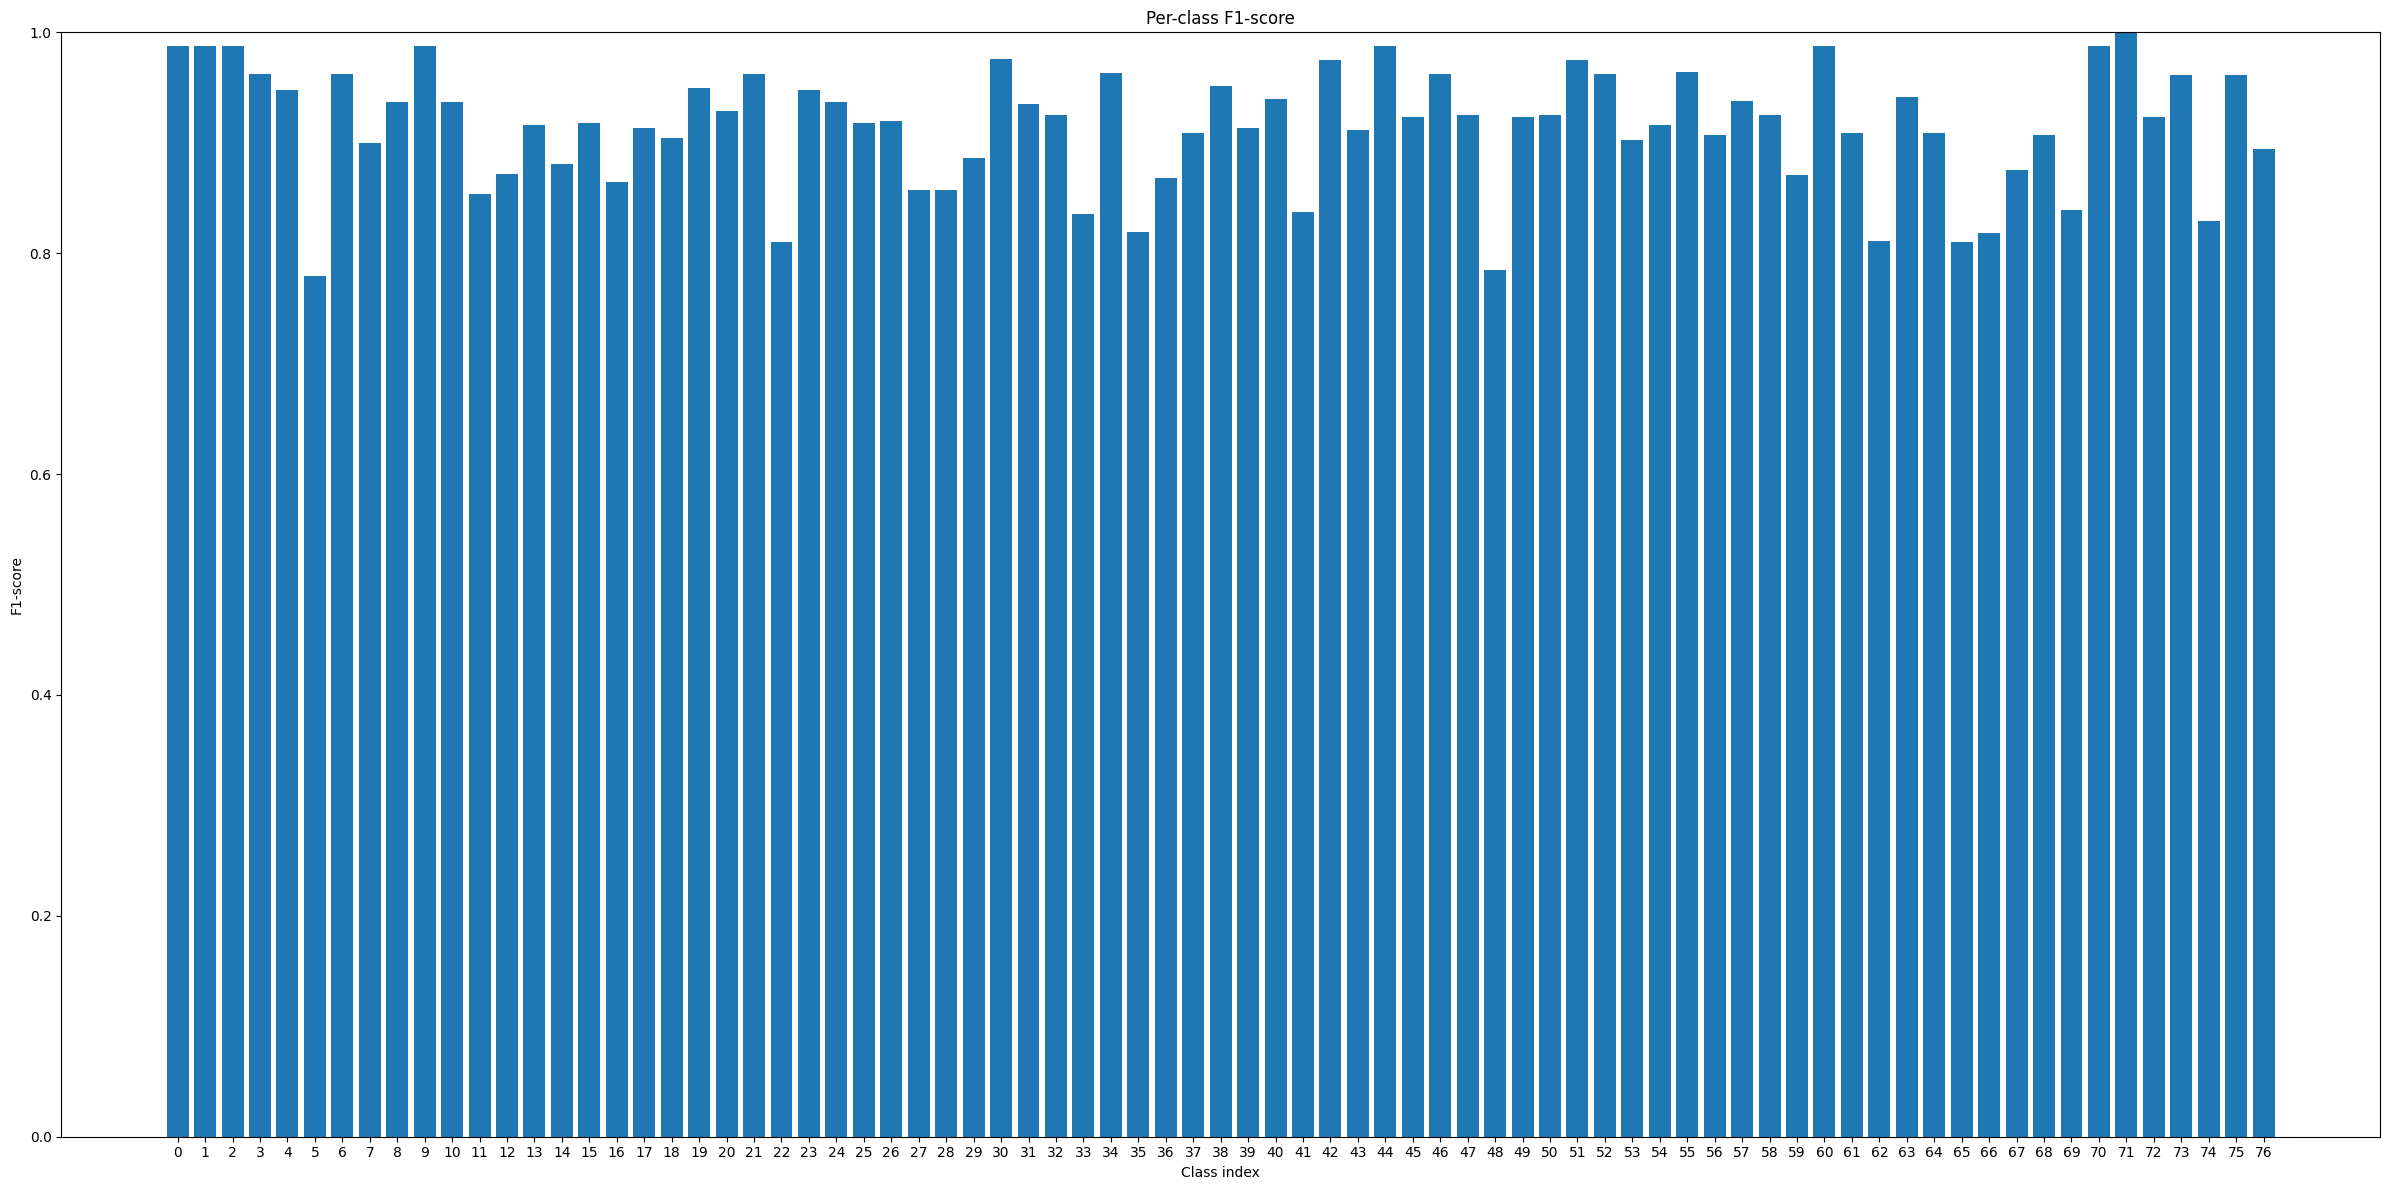

In [52]:
f1_per_class = f1_score(y_test, y_pred, average=None)

plt.figure(figsize=(24, 12))
plt.bar(range(len(f1_per_class)), f1_per_class)
plt.xlabel("Class index")
plt.ylabel("F1-score")
plt.title("Per-class F1-score")
plt.xticks(range(len(f1_per_class)))
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

lowest classes have their f1 score at about 0.8, majority has it above 0.9 which i'd consider satisfactory :)

5. Use Giskard for behavioral testing:
   - modify `prediction_function()` appropriately
   - HuggingFace pipeline has `top_k=None` option to get scores for all labels, not just the label
     with the highest probability
   - analyze the results, are there any additional problems with the resulting classifier?

In [53]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan, testing
from transformers import pipeline

trained_model = trainer.model
trained_model.eval()
model_pipeline = pipeline(
    "text-classification", 
    model=trained_model, 
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
)


@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    outputs = model_pipeline(df["text"].tolist(), top_k=None)
    probs = []
    for sample in outputs:
        probs.append([cls["score"] for cls in sample])

    return np.array(probs)


giskard_dataset = GiskardDataset(test_df.to_pandas(), target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=range(77),
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

Device set to use cuda


2025-11-25 02:04:33,879 pid:21060 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-25 02:04:33,880 pid:21060 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-11-25 02:04:33,886 pid:21060 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-25 02:04:33,924 pid:21060 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 3) executed in 0:00:00.041673
2025-11-25 02:04:33,927 pid:21060 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-25 02:04:33,933 pid:21060 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 3) executed in 0:00:00.008095
2025-11-25 02:04:33,936 pid:21060 MainThread giskard.datasets.base 

<iframe id="scan-2925795476112" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:

6. Use Captum for local explainability:
   - modify the `explain_text` function from the lab to accommodate multiclass classification
   - explain predictions for a few samples from a test set
   - comment, is the model focusing on the right parts of texts?

In [67]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:
    # make sure we compute gradients as necessary
    for param in model.distilbert.parameters():
        param.requires_grad = True

    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=y_true,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])

    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        y_pred = logits.argmax(dim=1).item()
        y_pred_proba = softmax(logits, dim=1)[0, y_pred].item()

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=labels_desc[y_pred],
        true_class=labels_desc[y_true],
        attr_class=labels_desc[y_true],
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])

In [70]:
df_test1 = pl.DataFrame({
    "text": datasets_tokenized["test"]["text"],
    "label": datasets_tokenized["test"]["label"],
})

positives = (
    df_test1
    .head(20)
    .to_dict(as_series=False)
)

In [71]:
for text, label in zip(positives["text"], positives["label"]):
    explain_text(model, text, label)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,lost_or_stolen_card (0.53),card_arrival,-1.55,how do i locate my card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,0.20,"i still have not received my new card , i ordered over a week ago ."


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.98),card_arrival,0.77,i ordered a card but it has not arrived . help please !


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_delivery_estimate (0.96),card_arrival,-0.05,is there a way to know when my card will arrive ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.98),card_arrival,0.35,my card has not arrived yet .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_delivery_estimate (0.97),card_arrival,0.27,when will i get my card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,0.45,do you know if there is a tracking number for the new card you sent me ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.98),card_arrival,-0.06,i have not received my card


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,0.09,still waiting on that card


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,-1.55,is it normal to have to wait over a week for my new card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,-0.92,how do i track my card ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_delivery_estimate (0.87),card_arrival,0.02,how long does a card delivery take ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,-0.32,i still don ' t have my card after 2 weeks . what should i do ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,0.12,still waiting on my new card


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,-0.63,i am still waiting for my card after 1 week . is this ok ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.75),card_arrival,0.06,"i have been waiting longer than expected for my bank card , could you provide information on when it will arrive ?"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.98),card_arrival,-0.19,i ' ve been waiting longer than expected for my card .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,-0.43,why hasn ' t my card been delivered ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,-1.14,where is my new card ? i have been waiting a week !


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
card_arrival,card_arrival (0.99),card_arrival,-1.39,my card still hasn ' t arrived after 2 weeks . is it lost ?


The model seems to be mostly paying attention to the important words (wait, arrive, card, bank) but there are some cases where models seems to pay extra attention to words like 'a' which is difficult to explain